**Importing all libraries**

In [ ]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew, norm
from sklearn.neighbors import KNeighborsRegressor
from google.colab import files
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
pd.options.mode.chained_assignment = None
# %matplotlib inline
warnings.filterwarnings('ignore')

**Loading the data**

In [ ]:
files.upload()

{}

In [ ]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

**Exploratory data analysis (EDA) and Visualization**

In [ ]:
print(test_data.info())
print(test_data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

**Let's explore our target variable and how the other features influence it.**

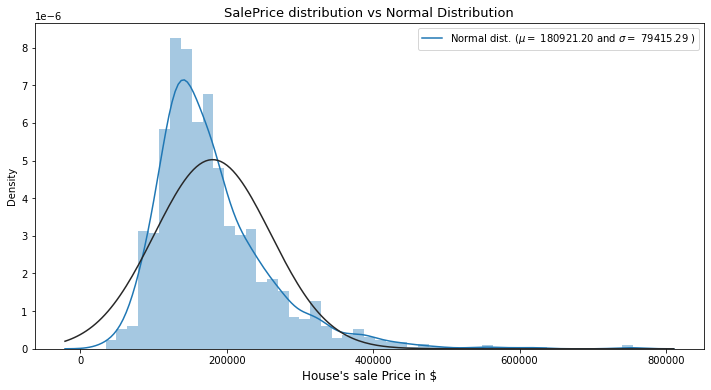

In [ ]:
(mu, sigma) = norm.fit(train_data['SalePrice'])

plt.figure(figsize=(12, 6))
sns.distplot(train_data['SalePrice'], kde=True, hist=True, fit=norm)
plt.title('SalePrice distribution vs Normal Distribution', fontsize=13)
plt.xlabel("House's sale Price in $", fontsize=12)
plt.legend([r'Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.show()

**The distribution does not seem to be normal, but highly right-skewed.**

In [ ]:
print("Skewness: %f" % abs(train_data['SalePrice']).skew())
print("Kurtosis: %f" % abs(train_data['SalePrice']).kurt())

Skewness: 1.882876
Kurtosis: 6.536282


**Correlation matrix**

Let's see which are the feature that correlate most with our target variable.

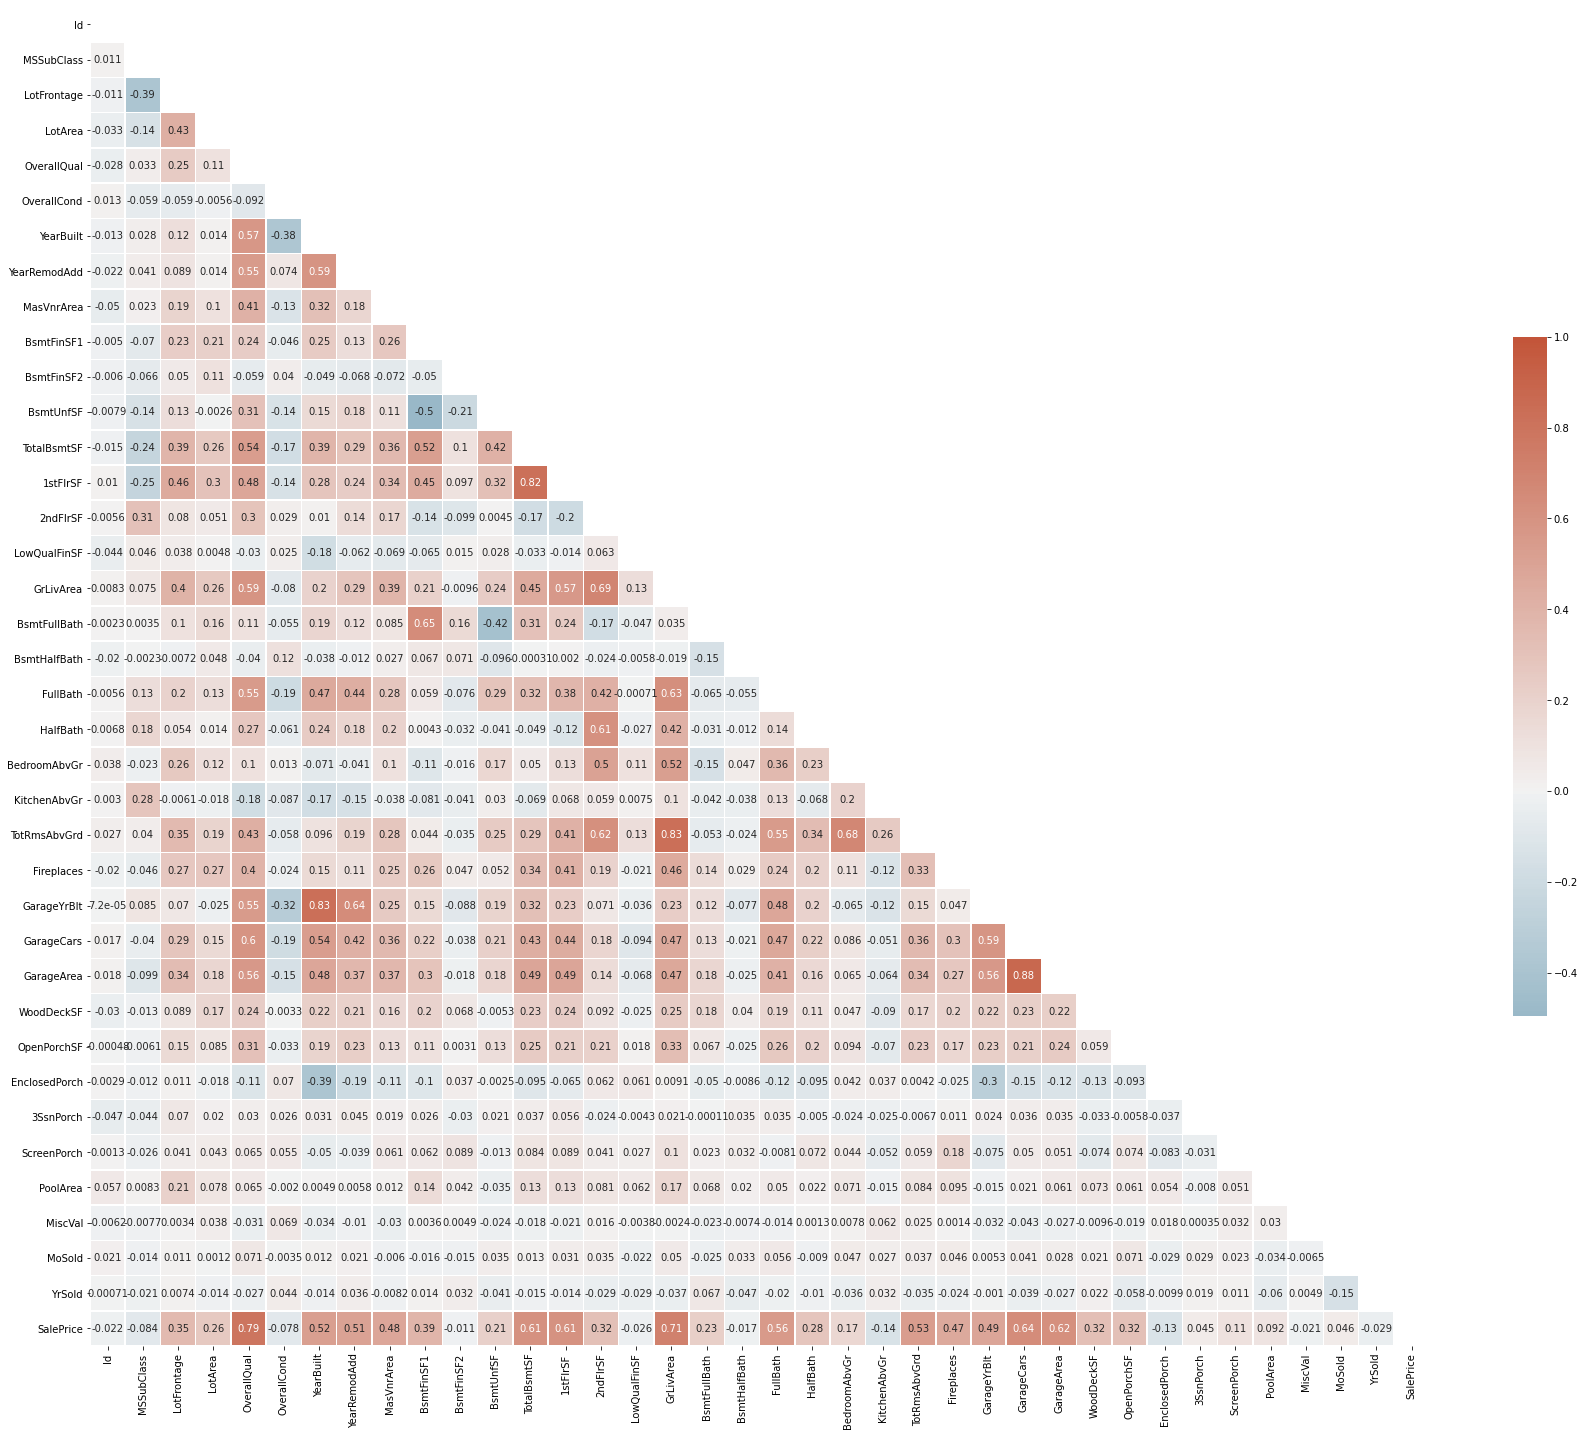

In [ ]:
f, ax = plt.subplots(figsize=(30, 25))
mat = train_data.corr('pearson')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

So we can see that **OverallQual, TotRmsAbvGrd, GrLivArea, TotalBsmtSF, YearBuilt, YrSold** features correlate most with our target variable.

**DATA PREPROCESSING**

Test dataset contains some observations not present in the training dataset.

The use of dummy coding could raise several issues, so let's concatenate 

Train and Test sets, preprocess, and divide them again.

In [ ]:
target = train_data['SalePrice']
test_id = test_data['Id']
test = test_data.drop(['Id'], axis=1)
train = train_data.drop(['SalePrice', 'Id'], axis=1)
train_test = pd.concat([train, test], axis=0, sort=False)

Let's check the amount of missed(Nan) values for each variable

In [ ]:
missed = pd.DataFrame(train_test.isna().sum(), columns=['Amount'])
missed['feat'] = missed.index
missed['Perc(%)'] = (missed['Amount'] / 1460) * 100
missed = missed[missed['Amount'] > 0]
missed = missed.sort_values(by=['Amount'])
missed

,Amount,feat,Perc(%)
TotalBsmtSF,1,TotalBsmtSF,0.068493
GarageArea,1,GarageArea,0.068493
GarageCars,1,GarageCars,0.068493
KitchenQual,1,KitchenQual,0.068493
Electrical,1,Electrical,0.068493
BsmtUnfSF,1,BsmtUnfSF,0.068493
BsmtFinSF2,1,BsmtFinSF2,0.068493
BsmtFinSF1,1,BsmtFinSF1,0.068493
SaleType,1,SaleType,0.068493
Exterior1st,1,Exterior1st,0.068493


Plotting missed(Nan)

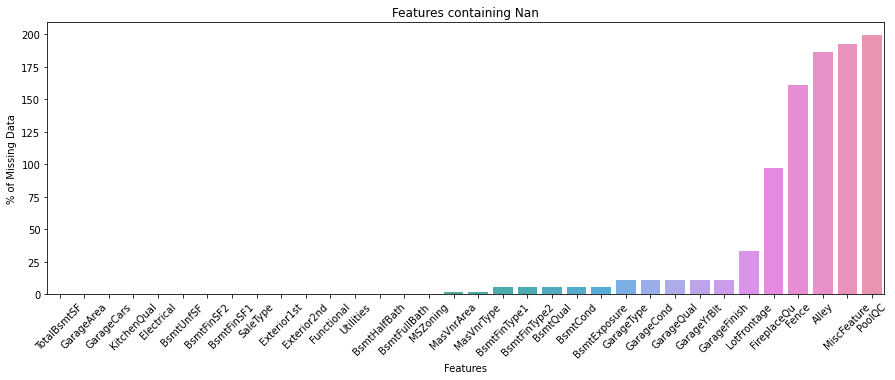

In [ ]:
plt.figure(figsize=(15, 5))
sns.barplot(x=missed['feat'], y=missed['Perc(%)'])
plt.xticks(rotation=45)
plt.title('Features containing Nan')
plt.xlabel('Features')
plt.ylabel('% of Missing Data')
plt.show()

Filling Categorical NaN

In [ ]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    train_test[col] = train_test[col].fillna('None')

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    train_test[col] = train_test[col].fillna('None')

for col in ('GarageArea', 'GarageCars'):
    train_test[col] = train_test[col].fillna(0)

In [ ]:
train_test["PoolQC"] = train_test["PoolQC"].fillna("None")
train_test["Alley"] = train_test["Alley"].fillna("None")
train_test['FireplaceQu'] = train_test['FireplaceQu'].fillna("None")
train_test['Fence'] = train_test['Fence'].fillna("None")
train_test['MiscFeature'] = train_test['MiscFeature'].fillna("None")
train_test['Functional'] = train_test['Functional'].fillna('Typ')
train_test['Electrical'] = train_test['Electrical'].fillna("SBrkr")
train_test['KitchenQual'] = train_test['KitchenQual'].fillna("TA")
train_test['Exterior1st'] = train_test['Exterior1st'].fillna(train_test['Exterior1st'].mode()[0])
train_test['Exterior2nd'] = train_test['Exterior2nd'].fillna(train_test['Exterior2nd'].mode()[0])
train_test['SaleType'] = train_test['SaleType'].fillna(train_test['SaleType'].mode()[0])

Converting non-numeric predictors stored as numbers into string

In [ ]:
train_test['MSSubClass'] = train_test['MSSubClass'].apply(str)
train_test['YrSold'] = train_test['YrSold'].apply(str)
train_test['MoSold'] = train_test['MoSold'].apply(str)

Removing the useless variables

In [ ]:
useless = ['GarageYrBlt', 'YearRemodAdd'] 
train_test = train_test.drop(useless, axis=1)

In [ ]:
# Imputing with KnnRegressor 


def impute_knn(df):
    ttn = train_test.select_dtypes(include=[np.number])
    ttc = train_test.select_dtypes(exclude=[np.number])

    cols_nan = ttn.columns[ttn.isna().any()].tolist()   
    cols_no_nan = ttn.columns.difference(cols_nan).values

    for col in cols_nan:
        imp_test = ttn[ttn[col].isna()]
        imp_train = ttn.dropna()    
        model = KNeighborsRegressor(n_neighbors=5)
        knr = model.fit(imp_train[cols_no_nan], imp_train[col])
        ttn.loc[ttn[col].isna(), col] = knr.predict(imp_test[cols_no_nan])

    return pd.concat([ttn, ttc], axis=1)


train_test = impute_knn(train_test)

objects = []
for i in train_test.columns:
    if train_test[i].dtype == object:
        objects.append(i)
train_test.update(train_test[objects].fillna('None'))

**FEATURE ENGINEERING**

In [ ]:
train_test["SqFtPerRoom"] = (train_test["GrLivArea"] / (train_test[
    "TotRmsAbvGrd"] + train_test["FullBath"] + train_test[
        "HalfBath"] + train_test["KitchenAbvGr"]))

train_test['Total_Home_Quality'] = (train_test[
    'OverallQual'] + train_test['OverallCond'])

train_test['Total_Bathrooms'] = (train_test[
    'FullBath'] + (0.5 * train_test['HalfBath']) + train_test[
        'BsmtFullBath'] + (0.5 * train_test['BsmtHalfBath']))

train_test["HighQualSF"] = train_test["1stFlrSF"] + train_test["2ndFlrSF"]

# Creating dummy variables from categorical features

train_test_dummy = pd.get_dummies(train_test)

# Fetch all numeric features

numeric_features = train_test_dummy.dtypes[
    train_test_dummy.dtypes != object].index
skewed_features = train_test_dummy[numeric_features].apply(
    lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[skewed_features > 0.5]
skew_index = high_skew.index

# Normalize skewed features using log_transformation

for i in skew_index:
    train_test_dummy[i] = np.log1p(train_test_dummy[i])

Let's use a log transformation in order to tranform our target distribution into a normal one

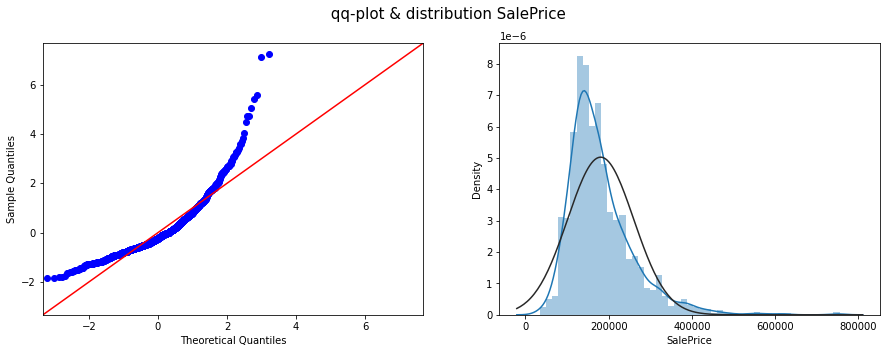

In [ ]:
# SalePrice before transformation

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle(" qq-plot & distribution SalePrice ", fontsize=15)

sm.qqplot(target, stats.t, distargs=(4,), fit=True, line="45", ax=ax[0])

sns.distplot(target, kde=True, hist=True, fit=norm, ax=ax[1])
plt.show()

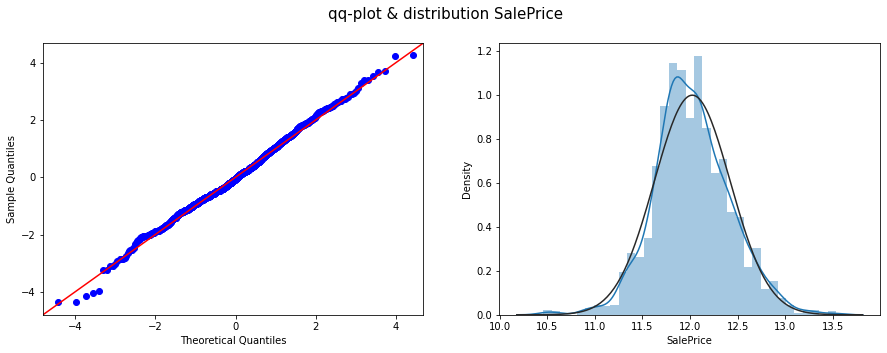

In [ ]:
# SalePrice after transformation

target_log = np.log1p(target)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("qq-plot & distribution SalePrice ", fontsize=15)

sm.qqplot(target_log, stats.t, distargs=(4,), fit=True, line="45", ax=ax[0])
sns.distplot(target_log, kde=True, hist=True, fit=norm, ax=ax[1])
plt.show()

**Modeling**

In [ ]:
# Train-Test separation

train = train_test_dummy[0:1460]
test = train_test_dummy[1460:]
test['Id'] = test_id

# Creation of the RMSE metric:


def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, train, target_log, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)


# 10 Fold Cross validation

kf = KFold(n_splits=10, random_state=42, shuffle=True)

cv_scores = []
cv_std = []

baseline_models = ['Linear_Reg.', 'Bayesian_Ridge_Reg.', 'LGBM_Reg.', 'SVR',
                   'Dec_Tree_Reg.', 'Random_Forest_Reg.', 'XGB_Reg.',
                   'Grad_Boost_Reg.', 'Cat_Boost_Reg.', 'Stacked_Reg.']

# Linear Regression

lreg = LinearRegression()
score_lreg = cv_rmse(lreg)
cv_scores.append(score_lreg.mean())
cv_std.append(score_lreg.std())

# Bayesian Ridge Regression

brr = BayesianRidge(compute_score=True)
score_brr = cv_rmse(brr)
cv_scores.append(score_brr.mean())
cv_std.append(score_brr.std())

# Light Gradient Boost Regressor

l_gbm = LGBMRegressor(objective='regression')
score_l_gbm = cv_rmse(l_gbm)
cv_scores.append(score_l_gbm.mean())
cv_std.append(score_l_gbm.std())

# Support Vector Regression

svr = SVR()
score_svr = cv_rmse(svr)
cv_scores.append(score_svr.mean())
cv_std.append(score_svr.std())

# Decision Tree Regressor

dtr = DecisionTreeRegressor()
score_dtr = cv_rmse(dtr)
cv_scores.append(score_dtr.mean())
cv_std.append(score_dtr.std())

# Random Forest Regressor

rfr = RandomForestRegressor()
score_rfr = cv_rmse(rfr)
cv_scores.append(score_rfr.mean())
cv_std.append(score_rfr.std())

# XGB Regressor

xgb = xgb.XGBRegressor()
score_xgb = cv_rmse(xgb)
cv_scores.append(score_xgb.mean())
cv_std.append(score_xgb.std())

# Gradient Boost Regressor

gbr = GradientBoostingRegressor()
score_gbr = cv_rmse(gbr)
cv_scores.append(score_gbr.mean())
cv_std.append(score_gbr.std())

# Cat Boost Regressor

catb = CatBoostRegressor()
score_catb = cv_rmse(catb)
cv_scores.append(score_catb.mean())
cv_std.append(score_catb.std())

# Stacked Regressor

stack_gen = StackingRegressor(regressors=(CatBoostRegressor(),
                                          LinearRegression(),
                                          BayesianRidge(),
                                          GradientBoostingRegressor()),
                              meta_regressor=CatBoostRegressor(),
                              use_features_in_secondary=True)

score_stack_gen = cv_rmse(stack_gen)
cv_scores.append(score_stack_gen.mean())
cv_std.append(score_stack_gen.std())

final_cv_score = pd.DataFrame(baseline_models, columns=['Regressors'])
final_cv_score['RMSE_mean'] = cv_scores
final_cv_score['RMSE_std'] = cv_std

Streaming output truncated to the last 5000 lines.
4:	learn: 0.3414853	total: 47.4ms	remaining: 9.43s
5:	learn: 0.3316433	total: 57ms	remaining: 9.44s
6:	learn: 0.3211509	total: 66.3ms	remaining: 9.41s
7:	learn: 0.3103063	total: 75.6ms	remaining: 9.37s
8:	learn: 0.3004232	total: 84.7ms	remaining: 9.33s
9:	learn: 0.2913387	total: 94.1ms	remaining: 9.32s
10:	learn: 0.2825164	total: 104ms	remaining: 9.32s
11:	learn: 0.2744322	total: 113ms	remaining: 9.29s
12:	learn: 0.2661866	total: 122ms	remaining: 9.28s
13:	learn: 0.2582783	total: 132ms	remaining: 9.28s
14:	learn: 0.2500908	total: 141ms	remaining: 9.24s
15:	learn: 0.2428382	total: 150ms	remaining: 9.21s
16:	learn: 0.2356782	total: 159ms	remaining: 9.22s
17:	learn: 0.2282247	total: 169ms	remaining: 9.21s
18:	learn: 0.2215927	total: 179ms	remaining: 9.23s
19:	learn: 0.2153214	total: 188ms	remaining: 9.23s
20:	learn: 0.2093555	total: 205ms	remaining: 9.54s
21:	learn: 0.2034759	total: 215ms	remaining: 9.54s
22:	learn: 0.1974005	total: 225ms

In [ ]:
final_cv_score

,Regressors,RMSE_mean,RMSE_std
0,Linear_Reg.,0.141219,0.030362
1,Bayesian_Ridge_Reg.,0.126294,0.025179
2,LGBM_Reg.,0.131067,0.020464
3,SVR,0.278721,0.022396
4,Dec_Tree_Reg.,0.207106,0.030870
5,Random_Forest_Reg.,0.138715,0.023275
6,XGB_Reg.,0.129390,0.018082
7,Grad_Boost_Reg.,0.129587,0.018805
8,Cat_Boost_Reg.,0.118625,0.018990
9,Stacked_Reg.,0.119256,0.020923


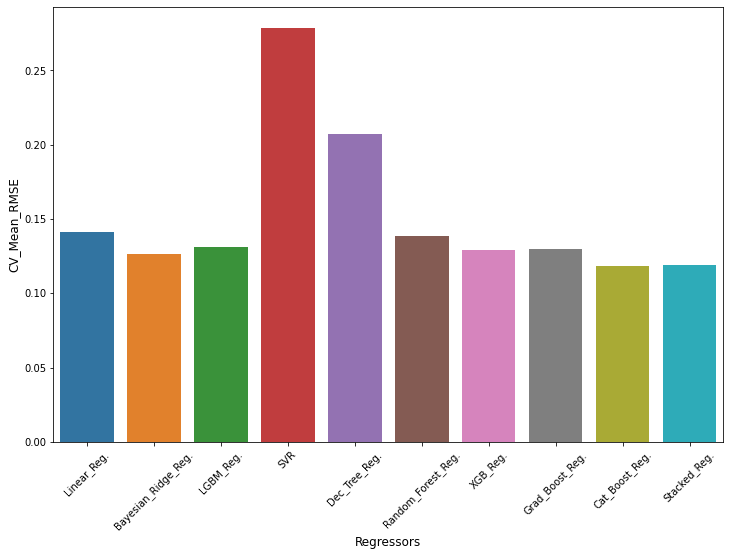

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(final_cv_score['Regressors'], final_cv_score['RMSE_mean'])
plt.xlabel('Regressors', fontsize=12)
plt.ylabel('CV_Mean_RMSE', fontsize=12)
plt.xticks(rotation=45)
plt.show()

As we can see Cat Boost Reg has the smallest Mean RMSE.

So we will use it for predicting results

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train, target_log, test_size=0.1, random_state=42)

# Cat Boost Regressor

params = {'iterations': 6000,
          'learning_rate': 0.005,
          'depth': 4,
          'l2_leaf_reg': 1,
          'eval_metric': 'RMSE',
          'early_stopping_rounds': 200,
          'verbose': 200,
          'random_seed': 42}

cat = CatBoostRegressor(**params)
cat_model = cat_f.fit(X_train, y_train,
                      eval_set=(X_val, y_val),
                      plot=True,
                      verbose=False)

cat_pred = cat_model_f.predict(X_val)
cat_score = rmse(y_val, catf_pred)

In [ ]:
cat_score

0.1082416716553218

**Submission**

In [ ]:
pred = cat_f.predict(test)
output = pd.DataFrame(test_id, columns=['Id'])
output['SalePrice'] = np.expm1(pred)
output.to_csv("submission.csv", index=False, header=True)